# 1.3 Regression logistique

Je n'ai pas reussi fini Regression logistique non plus. 

In [1]:
from Module import Lineaire, MSE, CrossEntropy, SigmoidModule
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

%load_ext autoreload
%autoreload 2

In [2]:
batch_size=64

loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, 
                          transform=transforms.Compose(
                              [transforms.ToTensor(),
                              transforms.Normalize((0.1307,),(0.3081,))]
                          )), 
    batch_size=batch_size, 
    shuffle=True
)

labels = loader.dataset.train_labels
label1 = 0
label2 = 1
mask = (labels == label1) + (labels == label2) > 0

loader.dataset.train_data = loader.dataset.train_data[mask]
loader.dataset.train_labels = loader.dataset.train_labels[mask]

labels = torch.where(loader.dataset.train_labels == label1, torch.ones(1), -torch.ones(1))
loader.dataset.train_labels = labels

full_dataset = loader.dataset.train_data
N = full_dataset.size()[0]
train_size = int(0.8 * N)
test_size = N - train_size
train_indices, test_indices = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    loader.dataset, 
    batch_size=batch_size, 
    sampler=SubsetRandomSampler(train_indices.indices)
)

test_loader = torch.utils.data.DataLoader(
    loader.dataset, 
    batch_size=batch_size, 
    sampler=SubsetRandomSampler(test_indices.indices)
)

In [25]:
torch.cuda.set_device(0)

dim_in = 28*28 + 1
dim_out = 1

epsilon = 0.0001
model = Lineaire(dim_in, dim_out)
model.initialize_parameters()
loss = CrossEntropy()
activation = SigmoidModule()


train_errors = []
test_errors = []



for epoch in range(20):
    if epoch % 10 == 0:
        print("Epoch {}".format(str(epoch)))
    train_error = 0
    for i,(data, y) in enumerate(train_loader):
        model.grad_zero()
        batch_n = data.size()[0]
        X = data.view(-1, batch_n)
        X = torch.cat((torch.ones((1,batch_n)), X), 0)
        
        #Forward pour obtenir l'erreur
        a0 = X
        z = model.forward(a0)
        a1 = activation.forward(z)
        
        train_error += loss.forward(y,a1)
        #import pdb; pdb.set_trace()
        error = loss.backward(y,a1)
        #Backward
        dZ = activation.backward_delta(error, a1)
        
        model.backward_update_gradient(a1 , dZ)
        model.update_parameters(epsilon)
    train_errors.append(train_error.numpy() / train_size) # mean
    
    continue
    test_error = 0
    for i,(data, y) in enumerate(test_loader):        
        batch_n = data.size()[0]
        X = data.view(-1, batch_n)
        X = torch.cat((torch.ones((1,batch_n)), X), 0)

        yhat = torch.sign(model.forward(X))
        
        test_error += loss.forward(y,yhat).sum()
    test_errors.append(test_error.numpy() / test_size) # mean

Epoch 0
Epoch 10


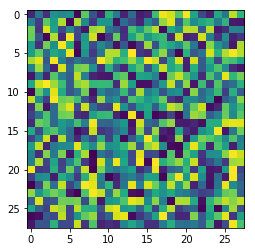

In [26]:
plt.imshow(model.W[1:].view(28,28))